# *(Laje & Buonomano)* Robust Timing in RNN

Implementation of the paper:

- Laje, Rodrigo, and Dean V. Buonomano. "Robust timing and motor patterns by taming chaos in recurrent neural networks." Nature neuroscience 16, no. 7 (2013): 925-933. http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3753043

Thanks to the original implementation codes: https://github.com/ReScience-Archives/Vitay-2016

In [1]:
import brainpy as bp
import brainpy.math as bm

## Model Descriptions

### Recurrent network

The recurrent network is composed of $N=800$ neurons, receiving inputs from a variable number of input neurons $N_i$ and sparsely connected with each other. Each neuron's firing rate $r_i(t)$ applies the `tanh` transfer function on an internal variable $x_i(t)$ which follows a first-order linear ordinary differential equation (ODE):

$$
\tau \cdot \frac{d x_i(t)}{dt} = - x_i(t) + \sum_{j=1}^{N_i} W_{ij}^{in} \cdot y_j(t) + \sum_{j=1}^{N} W_{ij}^{rec} \cdot r_j(t) + I^{noise}_i(t)
$$

$$
r_i(t) = \tanh(x_i(t))
$$

The weights of the input matrix $W^{in}$ are taken from the normal distribution, with mean 0 and variance 1, and multiply the rates of the input neurons $y_j(t)$. The variance of these weights does not depend on the number of inputs, as only one input neuron is activated at the same time. The recurrent connectivity matrix $W^{rec}$ is sparse with a connection probability $pc = 0.1$ (i.e. 64000 non-zero elements) and existing weights are taken randomly from a normal distribution with mean 0 and variance $g/\sqrt{pc \cdot N}$, where $g$ is a scaling factor. It is a well known result for sparse recurrent networks that for high values of $g$, the network dynamics become chaotic. $I^{noise}_i(t)$ is an additive noise, taken randomly at each time step and for each neuron from a normal distribution with mean 0 and variance $I_0$. $I_0$ is chosen very small in the experiments reproduced here ($I_0 = 0.001$) but is enough to highlight the chaotic behavior of the recurrent neurons (non-reproducibility between two trials).

### Read-out neurons

The read-out neurons simply sum the activity of the recurrent neurons using a matrix $W^{out}$:

$$
    z_i(t) = \sum_{j=1}^{N} W_{ij}^{out} \cdot r_j(t)
$$

The read-out matrix is initialized randomly from the normal distribution with mean 0 and variance $1/\sqrt{N}$.

### Learning rule

The particularity of the reservoir network proposed by *(Laje & Buonomano, Nature Neuroscience, 2013)* is that both the recurrent weights $W^{rec}$ and the read-out weights are trained in a supervised manner. More precisely, in this implementation, only 60% of the recurrent neurons have plastic weights, the 40% others keep the same weights throughout the simulation.

Learning is done using the recursive least squares (RLS) algorithm *(Haykin, 2002)*. It is a supervised error-driven learning rule, i.e. the weight changes depend on the error made by each neuron: the difference between the firing rate of a neuron $r_i(t)$ and a desired value $R_i(t)$.

$$
    e_i(t) = r_i(t) - R_i(t)
$$

For the recurrent neurons, the desired value is the recorded rate of that neuron during an initial trial (to enforce the reproducibility of the trajectory). For the read-out neurons, it is a function which we want the network to reproduce (e.g. handwriting as in Fig. 2).

Contrary to the delta learning rule which modifies weights proportionally to the error and to the direct input to a synapse ($\Delta w_{ij} = - \eta \cdot e_i \cdot r_j$), the RLS learning uses a running estimate of the inverse correlation matrix of the inputs to each neuron:

$$
    \Delta w_{ij} = - e_i \sum_{k \in \mathcal{B}(i)} P^i_{jk} \cdot r_k
$$

Each neuron $i$ therefore stores a square matrix $P^i$, whose size depends of the number of weights arriving to the neuron. Read-out neurons receive synapses from all $N$ recurrent neurons, so the $P$ matrix is $N*N$. Recurrent units have a sparse random connectivity ($pc = 0.1$), so each recurrent neuron stores only a $80*80$ matrix on average. In the previous equation, $\mathcal{B}(i)$ represents those existing weights.

The inverse correlation matrix $P$ is updated at each time step with the following rule:

$$
    \Delta P^i_{jk} = - \frac{\sum_{m \in \mathcal{B}(i)} \sum_{n \in \mathcal{B}(i)} P^i_{jm} \cdot r_m \cdot r_n \cdot P^i_{nk} }{ 1 + \sum_{m \in \mathcal{B}(i)} \sum_{n \in \mathcal{B}(i)} r_m \cdot P^i_{mn} \cdot r_n}
$$

Each matrix $P^i$ is initialized to the diagonal matrix and scaled by a factor $1/\delta$, where $\delta$ is 1 in the current implementation and can be used to modify implicitly the learning rate *(Sussilo & Larry, Neuron, 2009)*.

**Matrix/Vector mode**

The above algorithms can be written into the matrix/vector forms. For the recurrent units, each matrix $P^i$ has a different size ($80*80$ on average), so we will still need to iterate over all post-synaptic neurons. If we note $\mathbf{W}$ the vector of weights coming to a neuron (80 on average), $\mathbf{r}$ the corresponding vector of firing rates (also 80), $e$ the error of that neuron (a scalar) and $\mathbf{P}$ the inverse correlation matrix (80*80), the update rules become:
$$
    \Delta \mathbf{W} = - e \cdot \mathbf{P} \cdot \mathbf{r}
$$

$$
    \Delta \mathbf{P} = - \frac{(\mathbf{P} \cdot \mathbf{r}) \cdot (\mathbf{P} \cdot \mathbf{r})^T}{1 + \mathbf{r}^T \cdot \mathbf{P} \cdot \mathbf{r}}
$$

In the original Matlab code, one notices that the weight update $\Delta \mathbf{W}$ is also normalized by the denominator of the update rule for $\mathbf{P}$:

$$
    \Delta \mathbf{W} = - e \cdot \frac{\mathbf{P} \cdot \mathbf{r}}{1 + \mathbf{r}^T \cdot \mathbf{P} \cdot \mathbf{r}}
$$

Removing this normalization from the learning rule impairs learning completely, so we kept this variant of the RLS rule in our implementation.

### Training procedure

The training procedure is split into different trials, which differ from one experiment to another (Fig. 1, Fig. 2 and Fig. 3). Each trial begins with a relaxation period of `t_offset` = 200 ms, followed by a brief input impulse of duration 50 ms and variable amplitude. This impulse has the effect of bringing all recurrent neurons into a deterministic state (due to the `tanh` transfer function, the rates are saturated at either +1 or -1). This impulse is followed by a training window of variable length (in the seconds range) and finally another relaxation period. In Fig. 1 and Fig. 2, an additional impulse (duration 10 ms, smaller amplitude) can be given a certain delay after the initial impulse to test the ability of the network to recover its acquired trajectory after learning.

In all experiments, the first trial is used to acquire an innate trajectory for the recurrent neurons in the absence of noise ($I_0$ is set to 0). The firing rate of all recurrent neurons over the training window is simply recorded and stored in an array without applying the learning rules. This innate trajectory for each recurrent neuron is used in the following trials as the target for the RLS learning rule, this time in the presence of noise ($I_0 = 0.001$). The RLS learning rule itself is only applied to the recurrent neurons during the training window, not during the impulse or the relaxation periods. Such a learning trial is repeated 20 or 30 times depending on the experiments. Once the recurrent weights have converged and the recurrent neurons are able to reproduce the innate trajectory, the read-out weights are trained using a custom desired function as target (10 trials).

### References

- Laje, Rodrigo, and Dean V. Buonomano. "Robust timing and motor patterns by taming chaos in recurrent neural networks." Nature neuroscience 16, no. 7 (2013): 925-933.
- Haykin, Simon S. Adaptive filter theory. Pearson Education India, 2008.
- Sussillo, David, and Larry F. Abbott. "Generating coherent patterns of activity from chaotic neural networks." Neuron 63, no. 4 (2009): 544-557.

## Implementation

In [2]:
class RNN(bp.Base):
  target_backend = 'numpy'

  def __init__(self, num_input=2, num_rec=800, num_output=1, tau=10.0,
               g=1.5, pc=0.1, noise=0.001, delta=1.0, plastic_prob=0.6, dt=1.):
    super(RNN, self).__init__()

    # Copy the parameters
    self.num_input = num_input  # number of input neurons
    self.num_rec = num_rec  # number of recurrent neurons
    self.num_output = num_output  # number of read-out neurons
    self.tau = tau  # time constant of the neurons
    self.g = g  # synaptic strength scaling
    self.pc = pc  # connection probability
    self.noise = noise  # noise variance
    self.delta = delta  # initial value of the P matrix
    self.plastic_prob = plastic_prob  # percentage of neurons receiving plastic synapses
    self.dt = dt  # numerical precision

    # Initializes the network including the weight matrices.
    # ---

    # Recurrent population
    self.x = bm.Variable(bm.random.uniform(-1.0, 1.0, (self.num_rec,)))
    self.r = bm.Variable(bm.tanh(self.x))

    # Read-out population
    self.z = bm.Variable(bm.zeros(self.num_output, dtype=bm.float_))

    # Weights between the input and recurrent units
    self.W_in = bm.Variable(bm.random.randn(self.num_input, self.num_rec))

    # Weights between the recurrent units
    self.W_rec = bm.Variable(bm.random.randn(self.num_rec, self.num_rec) * self.g / bm.sqrt(self.pc * self.num_rec))

    # The connection pattern is sparse with p=0.1
    self.conn_mask = bm.random.random((self.num_rec, self.num_rec)) < self.pc
    diag = bm.arange(self.num_rec)
    self.conn_mask[diag, diag] = False
    self.W_rec *= bm.asarray(self.conn_mask, dtype=bm.float_)

    # Store the pre-synaptic neurons to each plastic neuron
    train_mask = bm.random.random((self.num_rec, self.num_rec)) < plastic_prob
    self.train_mask = bm.logical_and(train_mask, self.conn_mask)

    # Store the pre-synaptic neurons to each plastic neuron
    self.W_plastic = bm.Variable([bm.array(bm.nonzero(self.train_mask[i])[0]) for i in range(self.num_rec)])

    # Inverse correlation matrix of inputs for learning recurrent weights
    self.P_rec = bm.Variable([bm.identity(len(self.W_plastic[i])) / self.delta for i in range(self.num_rec)])

    # Output weights
    self.W_out = bm.Variable(bm.random.randn(self.num_output, self.num_rec) / bm.sqrt(self.num_rec))

    # Inverse correlation matrix of inputs for learning readout weights
    P_out = bm.expand_dims(bm.identity(self.num_rec) / self.delta, axis=0)
    self.P_out = bm.Variable(bm.repeat(P_out, self.num_output, axis=0))

    # loss
    self.loss = bm.Variable(bm.array([0.]))

  def simulate(self, stimulus, noise=True, target_traj=None,
               learn_start=-1, learn_stop=-1, learn_readout=False):
    """Simulates the recurrent network for the given duration, with or without plasticity.

    Parameters
    ----------

    stimulus : bm.ndarray
      The external inputs. 
    noise : bool
      if noise should be added to the recurrent units (default: True)
    target_traj : bm,ndarray
      During learning, defines which output target_traj function should be learned (default: no learning)
    learn_start : int, float
      Time when learning should start.
    learn_stop : int, float
      Time when learning should stop.
    learn_readout : bool
      Defines whether the recurrent (False) or readout (True) weights should be learned.
    """

    length, _ = stimulus.shape

    # Arrays for recording
    record_r = bm.zeros((length, self.num_rec), dtype=bm.float_)
    record_z = bm.zeros((length, self.num_output), dtype=bm.float_)

    # Reset the recurrent population
    self.x[:] = bm.random.uniform(-1.0, 1.0, (self.num_rec,))
    self.r[:] = bm.tanh(self.x)

    # Reset loss term
    self.loss[:] = 0.0

    # Simulate for the desired duration
    for i in range(length):
      # Update the neurons' firing rates
      self.update(stimulus[i, :], noise)

      # Recording
      record_r[i] = self.r
      record_z[i] = self.z

      # Learning
      if target_traj is not None and learn_stop > i * self.dt >= learn_start and i % 2 == 0:
        if not learn_readout:
          self.train_recurrent(target_traj[i])
        else:
          self.train_readout(target_traj[i])

    return record_r, record_z, self.loss

  def update(self, stimulus, noise=True):
    """Updates neural variables for a single simulation step."""
    dx = -self.x + bm.dot(stimulus, self.W_in) + bm.dot(self.W_rec, self.r)
    if noise:
      dx += self.noise * bm.random.randn(self.num_rec)
    self.x += dx / self.tau * self.dt
    self.r[:] = bm.tanh(self.x)
    self.z[:] = bm.dot(self.W_out, self.r)

  def train_recurrent(self, target):
    """Apply the RLS learning rule to the recurrent weights."""

    # Compute the error of the recurrent neurons
    error = self.r - target  # output_traj : (num_rec, )
    self.loss += bm.mean(error ** 2)

    # Apply the FORCE learning rule to the recurrent weights
    for i in range(self.num_rec):  # for each plastic post neuron
      # Get the rates from the plastic synapses only
      r_plastic = bm.expand_dims(self.r[self.W_plastic[i]], axis=1)
      # Multiply with the inverse correlation matrix P*R
      PxR = bm.dot(self.P_rec[i], r_plastic)
      # Normalization term 1 + R'*P*R
      RxPxR = (1. + bm.dot(r_plastic.T, PxR))
      # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
      self.P_rec[i][:] -= bm.dot(PxR, PxR.T) / RxPxR
      # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
      for j, idx in enumerate(self.W_plastic[i]):
        self.W_rec[i, idx] -= error[i] * (PxR[j, 0] / RxPxR[0, 0])

  def train_readout(self, target):
    """Apply the RLS learning rule to the readout weights."""

    # Compute the error of the output neurons
    error = self.z - target  # output_traj : (O, )
    # loss
    self.loss += bm.mean(error ** 2)
    # Apply the FORCE learning rule to the readout weights
    for i in range(self.num_output):  # for each readout neuron
      # Multiply the rates with the inverse correlation matrix P*R
      r = bm.expand_dims(self.r, axis=1)
      PxR = bm.dot(self.P_out[i], r)
      # Normalization term 1 + R'*P*R
      RxPxR = (1. + bm.dot(r.T, PxR))
      # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
      self.P_out[i] -= bm.dot(PxR, PxR.T) / RxPxR
      # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
      self.W_out[i] -= error[i] * (PxR / RxPxR)[:, 0]

  def init(self):
    # Recurrent population
    self.x[:] = bm.random.uniform(-1.0, 1.0, (self.num_rec,))
    self.r[:] = bm.tanh(self.x)

    # Read-out population
    self.z[:] = bm.zeros((self.num_output,))

    # Weights between the input and recurrent units
    self.W_in[:] = bm.random.randn(self.num_input, self.num_rec)

    # Weights between the recurrent units
    self.W_rec[:] = bm.random.randn(self.num_rec, self.num_rec) * self.g / bm.sqrt(self.pc * self.num_rec)
    self.W_rec *= self.conn_mask

    # Inverse correlation matrix of inputs for learning recurrent weights
    for i in range(self.num_rec):
      self.P_rec[i][:] = bm.identity(len(self.W_plastic[i])) / self.delta

    # Output weights
    self.W_out[:] = bm.random.randn(self.num_output, self.num_rec) / bm.sqrt(self.num_rec)

    # Inverse correlation matrix of inputs for learning readout weights
    P_out = bm.expand_dims(bm.identity(self.num_rec) / self.delta, axis=0)
    self.P_out[:] = bm.repeat(P_out, self.num_output, axis=0)

    # loss
    self.loss[:] = 0.

## Results

In [3]:
from Laje_Buonomano_2013_simulation import *

The ``simulation.py`` can be downloaded from [here](./Laje_Buonomano_2013_simulation.ipynb).

### Fig. 1: an initially chaotic network can become deterministic after training

C:\Users\adadu\miniconda3\envs\brainmodels\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\adadu\miniconda3\envs\brainmodels\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Initial trial to determine a target_traj (without noise)
Pre-training test trial
5 perturbation trials
Learning trial recurrent 1 loss: 0.141811, time: 14.100062131881714 s
Learning trial recurrent 2 loss: 0.193710, time: 12.426777839660645 s
Learning trial recurrent 3 loss: 0.195481, time: 12.623185634613037 s
Learning trial recurrent 4 loss: 0.191801, time: 12.061197519302368 s
Learning trial recurrent 5 loss: 0.146302, time: 12.319267749786377 s
Learning trial recurrent 6 loss: 0.116965, time: 12.173625469207764 s
Learning trial recurrent 7 loss: 0.172879, time: 12.333614826202393 s
Learning trial recurrent 8 loss: 0.133463, time: 12.423139333724976 s
Learning trial recurrent 9 loss: 0.130180, time: 12.330845355987549 s
Learning trial recurrent 10 loss: 0.111944, time: 12.26445198059082 s
Learning trial recurrent 11 loss: 0.164418, time: 12.31094241142273 s
Learning trial recurrent 12 loss: 0.098953, time: 12.424531698226929 s
Learning trial recurrent 13 loss: 0.069846, time: 12.460

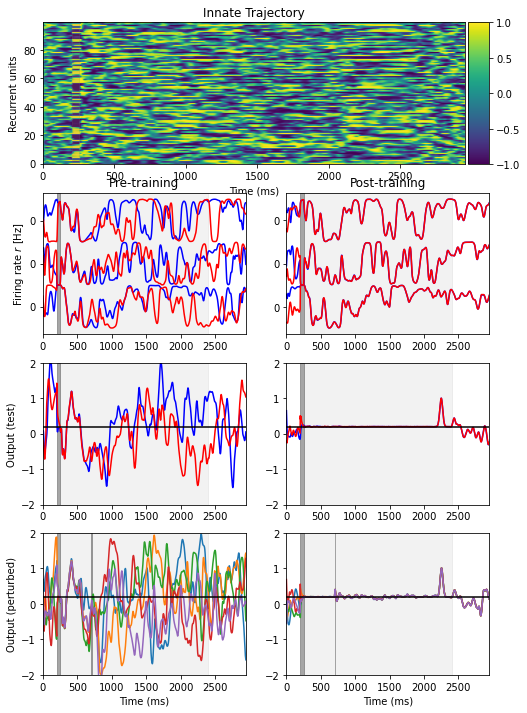

In [4]:
net = RNN(
  num_input=2,  # Number of inputs
  num_rec=800,  # Number of recurrent neurons
  num_output=1,  # Number of read-out neurons
  tau=10.0,  # Time constant of the neurons
  g=1.8,  # Synaptic strength scaling
  pc=0.1,  # Connection probability
  noise=0.001,  # Noise variance
  delta=1.0,  # Initial diagonal value of the P matrix
  plastic_prob=0.6,  # Percentage of neurons receiving plastic synapses
  dt=1.,
)
net.update = bp.math.jit(net.update)
net.train_recurrent = bp.math.jit(net.train_recurrent)

fig1(net)

### Fig. 2: read-out neurons robustly learn trajectories in the 2D space

C:\Users\adadu\miniconda3\envs\brainmodels\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\adadu\miniconda3\envs\brainmodels\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Initial chaos trial
Initial neuron trial
Learning recurrent 1 "chaos" loss: 0.03024 used 9.585194 s, "neuron" loss: 0.068696 used 7.557857 s
Learning recurrent 2 "chaos" loss: 0.04035 used 7.712137 s, "neuron" loss: 0.049718 used 7.040077 s
Learning recurrent 3 "chaos" loss: 0.03334 used 7.632152 s, "neuron" loss: 0.038121 used 6.890412 s
Learning recurrent 4 "chaos" loss: 0.03709 used 7.543250 s, "neuron" loss: 0.027921 used 6.712800 s
Learning recurrent 5 "chaos" loss: 0.03522 used 7.641539 s, "neuron" loss: 0.030041 used 7.152696 s
Learning recurrent 6 "chaos" loss: 0.02818 used 7.359621 s, "neuron" loss: 0.024535 used 6.964830 s
Learning recurrent 7 "chaos" loss: 0.02867 used 7.660184 s, "neuron" loss: 0.025658 used 7.088823 s
Learning recurrent 8 "chaos" loss: 0.02053 used 7.319214 s, "neuron" loss: 0.025591 used 7.207662 s
Learning recurrent 9 "chaos" loss: 0.02193 used 7.674067 s, "neuron" loss: 0.018955 used 7.258080 s
Learning recurrent 10 "chaos" loss: 0.01775 used 7.495978 s

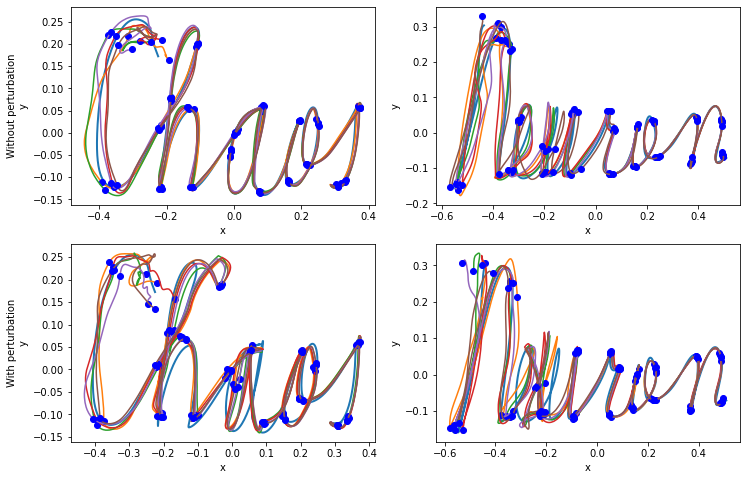

In [4]:
net = RNN(
  num_input=4,  # Number of inputs
  num_rec=800,  # Number of recurrent neurons
  num_output=2,  # Number of read-out neurons
  tau=10.0,  # Time constant of the neurons
  g=1.5,  # Synaptic strength scaling
  pc=0.1,  # Connection probability
  noise=0.001,  # Noise variance
  delta=1.0,  # Initial value of the P matrix
  plastic_prob=0.6,  # Percentage of neurons receiving plastic synapses
  dt=1.
)
net.update = bp.math.jit(net.update)
net.train_recurrent = bp.math.jit(net.train_recurrent)
net.train_readout = bp.math.jit(net.train_readout)

fig2(net)

### Fig. 3: the timing capacity of the recurrent network

C:\Users\adadu\miniconda3\envs\brainmodels\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\adadu\miniconda3\envs\brainmodels\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\adadu\miniconda3\envs\brainmodels\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple

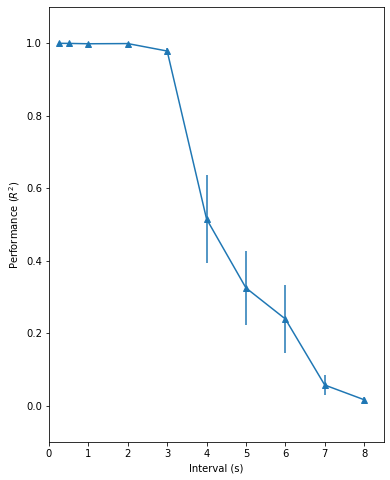

In [4]:
nets = []
for _ in range(10):
  net = RNN(
    num_input=2,  # Number of inputs
    num_rec=800,  # Number of recurrent neurons
    num_output=1,  # Number of read-out neurons
    tau=10.0,  # Time constant of the neurons
    g=1.5,  # Synaptic strength scaling
    pc=0.1,  # Connection probability
    noise=0.001,  # Noise variance
    delta=1.0,  # Initial diagonal value of the P matrix
    plastic_prob=0.6,  # Percentage of neurons receiving plastic synapses
    dt=1.
  )
  net.update = bp.math.jit(net.update)
  net.train_recurrent = bp.math.jit(net.train_recurrent)
  nets.append(net)

fig3(nets, verbose=False)